dataset: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

In [1]:
import numpy as np 
import pandas as pd
import cv2
import torch
import torchvision
from torchvision import utils as vutils
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torch.optim import SGD, Adam
from PIL import Image
import matplotlib.pyplot as plt
import os
from statistics import mean
import cv2
import numpy as np
from sklearn.cluster import KMeans
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pyshearlab


In [2]:
'''
Extract number of positive vs negative samples (where negative samples have an all-zero mask)
Check for files without corresponding mask and vice versa
'''
root = 'lgg-mri-segmentation/kaggle_3m'

no_mask = 0
no_mask_files = []
no_file = 0
no_files = []
num_empty_masks = 0
num_nonempty_masks = 0

S = 3 # number of pos/neg samples to take
empty_mask_samples = []
nonempty_mask_samples = []

img_dimensions = []
msk_dimensions = []

n_files = 0
for directory in [os.path.join(root,x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        n_files += 1
        img_dimensions.append(np.array(cv2.imread(os.path.join(directory, file))).shape)
        #count files with no mask
        if 'mask' not in file:
            #check if mask exists
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')
            if not os.path.exists(mask_path):
                no_mask += 1
                no_mask_files.append(os.path.join(directory, file))
        else:
            msk_dimensions.append(np.array(cv2.imread(os.path.join(directory, file), cv2.IMREAD_UNCHANGED)).shape)
            #count masks with no file
            f_path = os.path.join(directory, file[:file.find('mask')-1]+'.tif')
            #check if file exists
            if not os.path.exists(f_path):
                no_file += 1
                no_files.append(os.path.join(directory, file))
                
            #check if mask is empty
            j = np.max(cv2.imread(os.path.join(directory, file), cv2.IMREAD_UNCHANGED))
            if j > 0:
                num_nonempty_masks += 1
                if len(nonempty_mask_samples) < S:
                    nonempty_mask_samples.append(os.path.join(directory, file))
            else:
                num_empty_masks += 1
                if len(empty_mask_samples) < S:
                    empty_mask_samples.append(os.path.join(directory, file))

In [3]:
#check variance in dimensions
print('Image Dimensions')
print(len(set(img_dimensions)))
print(set(img_dimensions))
print('Mask Dimensions')
print(len(set(msk_dimensions)))
print(set(msk_dimensions))

Image Dimensions
1
{(256, 256, 3)}
Mask Dimensions
1
{(256, 256)}


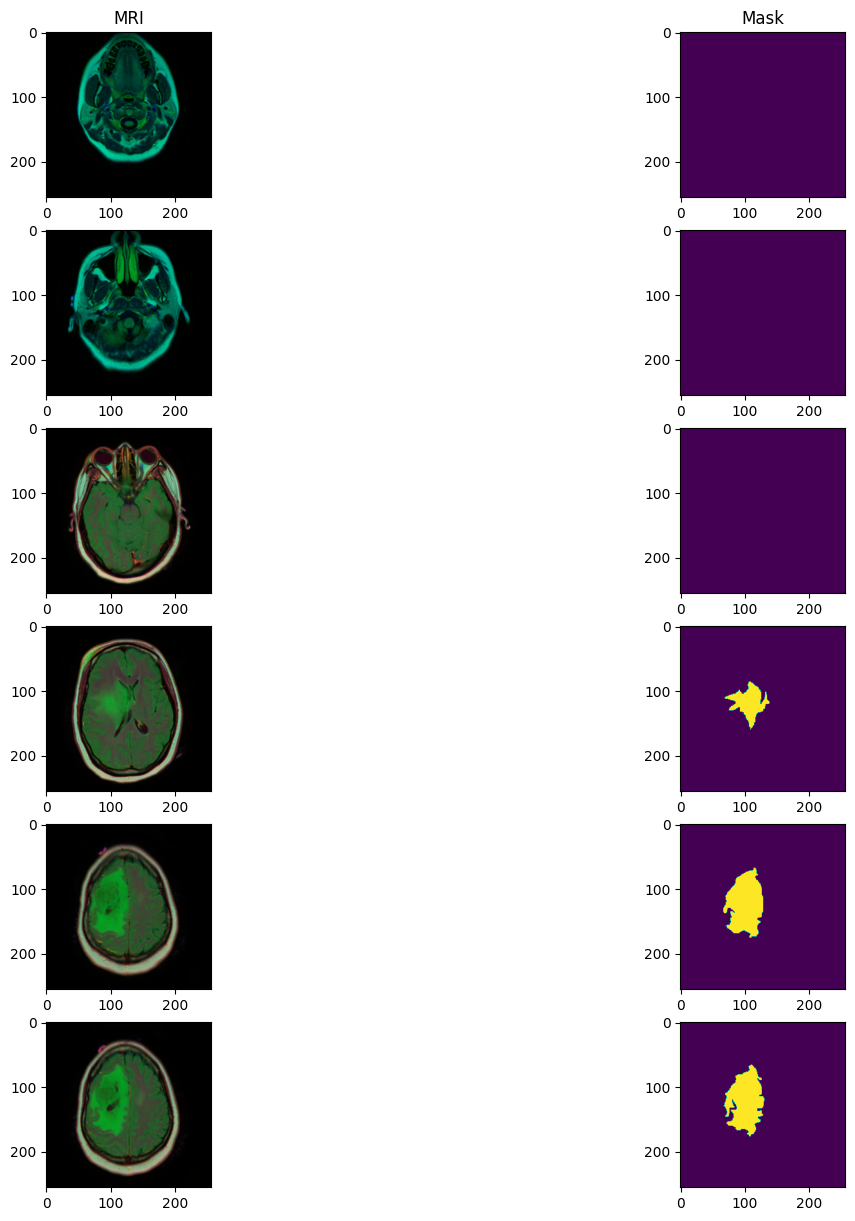

In [4]:
#display images of negative and positive samples - negative samples have an empty mask
fig, axs = plt.subplots(6,2, figsize=(15,15))
for ax, col in zip(axs[0], ['MRI', 'Mask']):
    ax.set_title(col)
    
display_imgs = empty_mask_samples+nonempty_mask_samples #concat lists for easy plotting
#print(display_imgs)
for i in range(len(display_imgs)):
    mask_path = display_imgs[i]
    img_path = mask_path[:mask_path.find('mask')-1]+'.tif'
    axs[i,0].imshow(np.array(cv2.imread(img_path)))
    axs[i,1].imshow(np.array(cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)))

In [5]:
#store list of train files for dataset creation of the form (train_img, mask_img, pos_neg_result(1/0))
#these tuples are fed into the datasets we create below
file_list = []
for directory in [os.path.join(root,x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        #add files to list
        if 'mask' not in file:
            result = 0
            img_path = os.path.join(directory, file)
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')
                
            #check if mask is nonempty
            if np.max(cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)) > 0:
                result = 1
            
            file_list.append([img_path, mask_path, result])

In [6]:
# for classification

class Brain_MRI_Classification_Dataset(data.Dataset):
    def __init__(self, inputs, transform=None):
        self.inputs = inputs
        self.transform = transform
        self.input_dtype = torch.float32
        self.target_dtype = torch.float32
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        #for classification return only the image and the binary label
        img_path = self.inputs[index][0]
        image = cv2.imread(img_path)
        x = torch.from_numpy(np.transpose(np.array(image), (2,0,1))).type(self.input_dtype)
        y = torch.from_numpy(np.array(self.inputs[index][2])).type(self.target_dtype)
        
        if self.transform is not None:
            x = self.transform(x)
        
        return x,y

In [7]:
# for segmentation

class Brain_MRI_Segmentation_Dataset(data.Dataset):
    def __init__(self, inputs, transform=None):
        self.inputs = inputs
        self.transform = transform
        self.input_dtype = torch.float32
        self.target_dtype = torch.float32
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        #for classification return only the image and the binary label
        img_path = self.inputs[index][0]
        mask_path = self.inputs[index][1]
        #mask_img = cv2.normalize(cv2.imread(mask_path), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        x = torch.from_numpy(np.transpose(np.array(cv2.imread(img_path)), (2,0,1))).type(self.input_dtype)
        y = torch.from_numpy(np.resize(np.array(mask_img)/255., (1,256,256))).type(self.target_dtype)
        
        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
        
        return x,y

In [8]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1)
    
    bin_out = torch.where(outputs > threshold, 1, 0).type(torch.int16)
    labels = labels.type(torch.int16)
    
    intersection = (bin_out & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (bin_out | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch

In [9]:
#Dice Loss Function - taken from: https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [10]:
#combined cross entropy and dice loss
def bce_dice_loss(output, target):
    bce = nn.BCEWithLogitsLoss()
    return bce(output, target) + dice_loss(output, target)

In [58]:
def plot_training_scores(losses, train_scores):
    for i in range(len(losses)):
        # losses[i] = losses[i].cpu().detach().numpy()
        train_scores[i] = train_scores[i].cpu().detach()

    #plot loss and IoU
    fig, axs = plt.subplots(1,2, figsize=(5,5))
    axs[0].set_title('Train BCE Loss')
    axs[0].plot(range(len(losses)), losses)

    axs[1].set_title('IoU Score vs Training Step')
    axs[1].plot(range(len(train_scores)), train_scores)
    
    print(f'MEAN TRAIN IOU: {torch.mean(torch.tensor(train_scores))}')

def plot_validation_scores(val_losses, val_scores):
    for i in range(len(val_losses)):
        # val_losses[i] = val_losses[i].cpu().detach().numpy()
        val_scores[i] = val_scores[i].cpu().detach()
    #plot loss and IoU scores - we use a histogram because we care about the distribution of losses, not its progression
    fig, axs = plt.subplots(1,2, figsize=(7,7))
    axs[0].set_title('BCE Loss on Validation Set')
    axs[0].hist(val_losses)

    temp = [t.cpu().item() for t in val_scores]
    axs[1].set_title('IoU Scores on Validation Set')
    axs[1].hist(temp)
    axs[1].axvline(np.median(np.array(temp)), color='k', linestyle='dashed', linewidth=1)
    print(f'MEAN VAL IOU: {mean(temp)}')

def visualize_segmentation(model, data_loader, num_samples=5, device='cuda:1'):
    #visualize segmentation on unseen samples
    fig, axs = plt.subplots(num_samples, 3, figsize=(60,60))

    for ax, col in zip(axs[0], ['MRI', 'Ground Truth', 'Predicted Mask']):
        ax.set_title(col)

    index = 0
    for i,batch in enumerate(data_loader):
            img = batch[0].to(device)
            msk = batch[1].to(device)

            output = model(img)

            for j in range(batch[0].size()[0]): #iterate over batchsize
                axs[index,0].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.uint8)[:,:,0:3], cmap='bone', interpolation='none')

                axs[index,1].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.uint8)[:,:,0:3], cmap='bone', interpolation='none')
                axs[index,1].imshow(torch.squeeze(msk[j]).detach().cpu().numpy(), cmap='Blues', interpolation='none', alpha=0.5)

                axs[index,2].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.uint8)[:,:,0:3], cmap='bone', interpolation='none')
                axs[index,2].imshow(torch.squeeze(output[j]).detach().cpu().numpy(), cmap='Greens', interpolation='none', alpha=0.5)

                index += 1

            if index >= num_samples:
                break

    plt.tight_layout()

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        return self.sequence(x)
        
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            ConvBlock(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.sequence(x)
        
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        #input_dim = 256
        self.encoder = nn.ModuleList([
            DownConv(in_channels, 64), #128
            DownConv(64, 128), #64
            DownConv(128, 256), #32
            DownConv(256, 512) #16
        ])
        
        self.bottleneck = ConvBlock(512, 1024)
        
        #extra channels allow for concatenation of skip connections in upsampling block
        self.decoder = nn.ModuleList([
            UpConv(512+1024,512), #32
            UpConv(256+512,256), #64
            UpConv(128+256,128), #128
            UpConv(64+128,64) #256
        ])
        
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        skips = []
        o = x
        for layer in self.encoder:
            o = layer(o)
            skips.append(o)
        
        o = self.bottleneck(o)
        
        for i, layer in enumerate(self.decoder):
            #print(o.size())
            o = torch.cat((skips[len(skips)-i-1],o), dim=1)
            #print(o.size())
            o = layer(o)
        
        return self.output_conv(o)

In [29]:
class ConvAutoencoder(nn.Module):
    def __init__(self, input_channels, im_size):
        super(ConvAutoencoder, self).__init__()
        
        assert im_size % 8 == 0, "im_size must be a multiple of 8"
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            # nn.Sigmoid(),
        )



    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # sum along second dimension (channels)
        x = torch.sum(x, dim=1)
        x= torch.unsqueeze(x, 1)
        return x

In [36]:
def shear_filter(image):
    # convert from torch to numpy
    image=0.2989*image[0]+0.5870*image[1]+0.1140*image[2]
    image = image.numpy().astype(np.float64)


    # Initialize the Shearlet system
    SL = pyshearlab.SLgetShearletSystem2D(0, image.shape[0], image.shape[1], 2)

    # Perform the shearlet transform
    coeffs = pyshearlab.SLsheardec2D(image, SL)
    coeffs= coeffs[:,:,0:-2]

    shear_decomposition= torch.from_numpy(coeffs).permute(2,0,1).float()
    return shear_decomposition



In [37]:
def transforming(image):
        segmented_image = shear_filter(image)
        return segmented_image


Initializing stuff

In [38]:
#load data
positive_diagnoses = [x for x in file_list if x[2] == 1]
mri_dataset = Brain_MRI_Segmentation_Dataset(positive_diagnoses)

inputs=[]
labels=[]
for i in range(len(mri_dataset)):
    inputs.append(transforming(mri_dataset[i][0]))
    labels.append(mri_dataset[i][1])

inputs=torch.stack(inputs)
labels=torch.stack(labels)

# convert to torch dataset
mri_dataset = data.TensorDataset(inputs, labels)
    

validation_size = int(0.3 * len(mri_dataset))
train_set, val_set = data.random_split(mri_dataset, [len(mri_dataset)-validation_size, validation_size])

train_loader = data.DataLoader(dataset=train_set, batch_size=2, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, batch_size=2, shuffle=False)


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

num_epochs = 50

# model = ConvAutoencoder(input_channels=1, im_size=256).to(device)
model=UNet(in_channels=15, out_channels=1).to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [52]:
   
#######################
#Train model          #
#######################
print('Model sent to ' + str(device))
model.to(device)
losses = []
train_scores = [] # hold IoU scores
iters = 0
for epoch in range(num_epochs):
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}')
    
    for i,batch in enumerate(train_loader):
        img = batch[0].to(device)
        msk = batch[1].to(device)

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, msk)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_scores.append(iou_pytorch(output.detach(), msk))

        iters += 1

        #if iters % 500 == 0:
            #print(f'Loss: [{loss}]')
            
#for i in range(len(train_scores)):
    #   train_scores[i] = train_scores[i].mean()
    


Model sent to cuda:0
Epoch 1/50


Epoch 11/50
Epoch 21/50
Epoch 31/50
Epoch 41/50


In [53]:
#######################
#Validate model       #
#######################

model.eval()
val_losses = []
val_scores = []

for i,batch in enumerate(val_loader):
    img = batch[0].to(device)
    msk = batch[1].to(device)

    output = model(img)
    loss = criterion(output, msk)
    val_scores.append(iou_pytorch(output.detach(), msk))
    val_losses.append(loss.item())
        
results = {
    'model_name': 'UNet',
    'train_losses': losses,
    'train_scores': train_scores,
    'val_losses': val_losses,
    'val_scores': val_scores
}





MEAN TRAIN IOU: 0.7691788077354431
MEAN VAL IOU: 0.4334951523438241


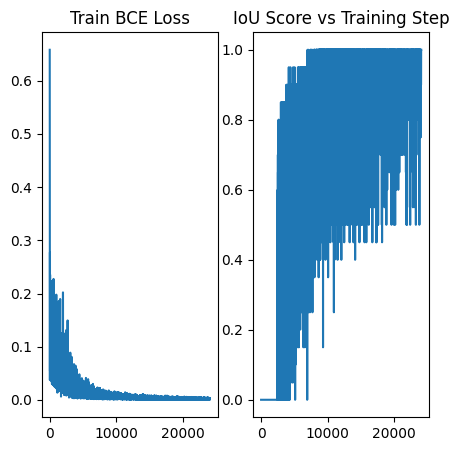

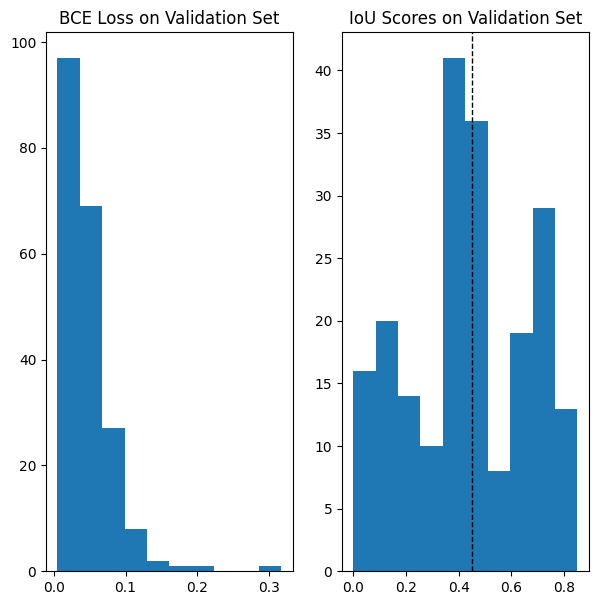

In [54]:
plot_training_scores(results['train_losses'], results['train_scores'])
plot_validation_scores(results['val_losses'], results['val_scores'])

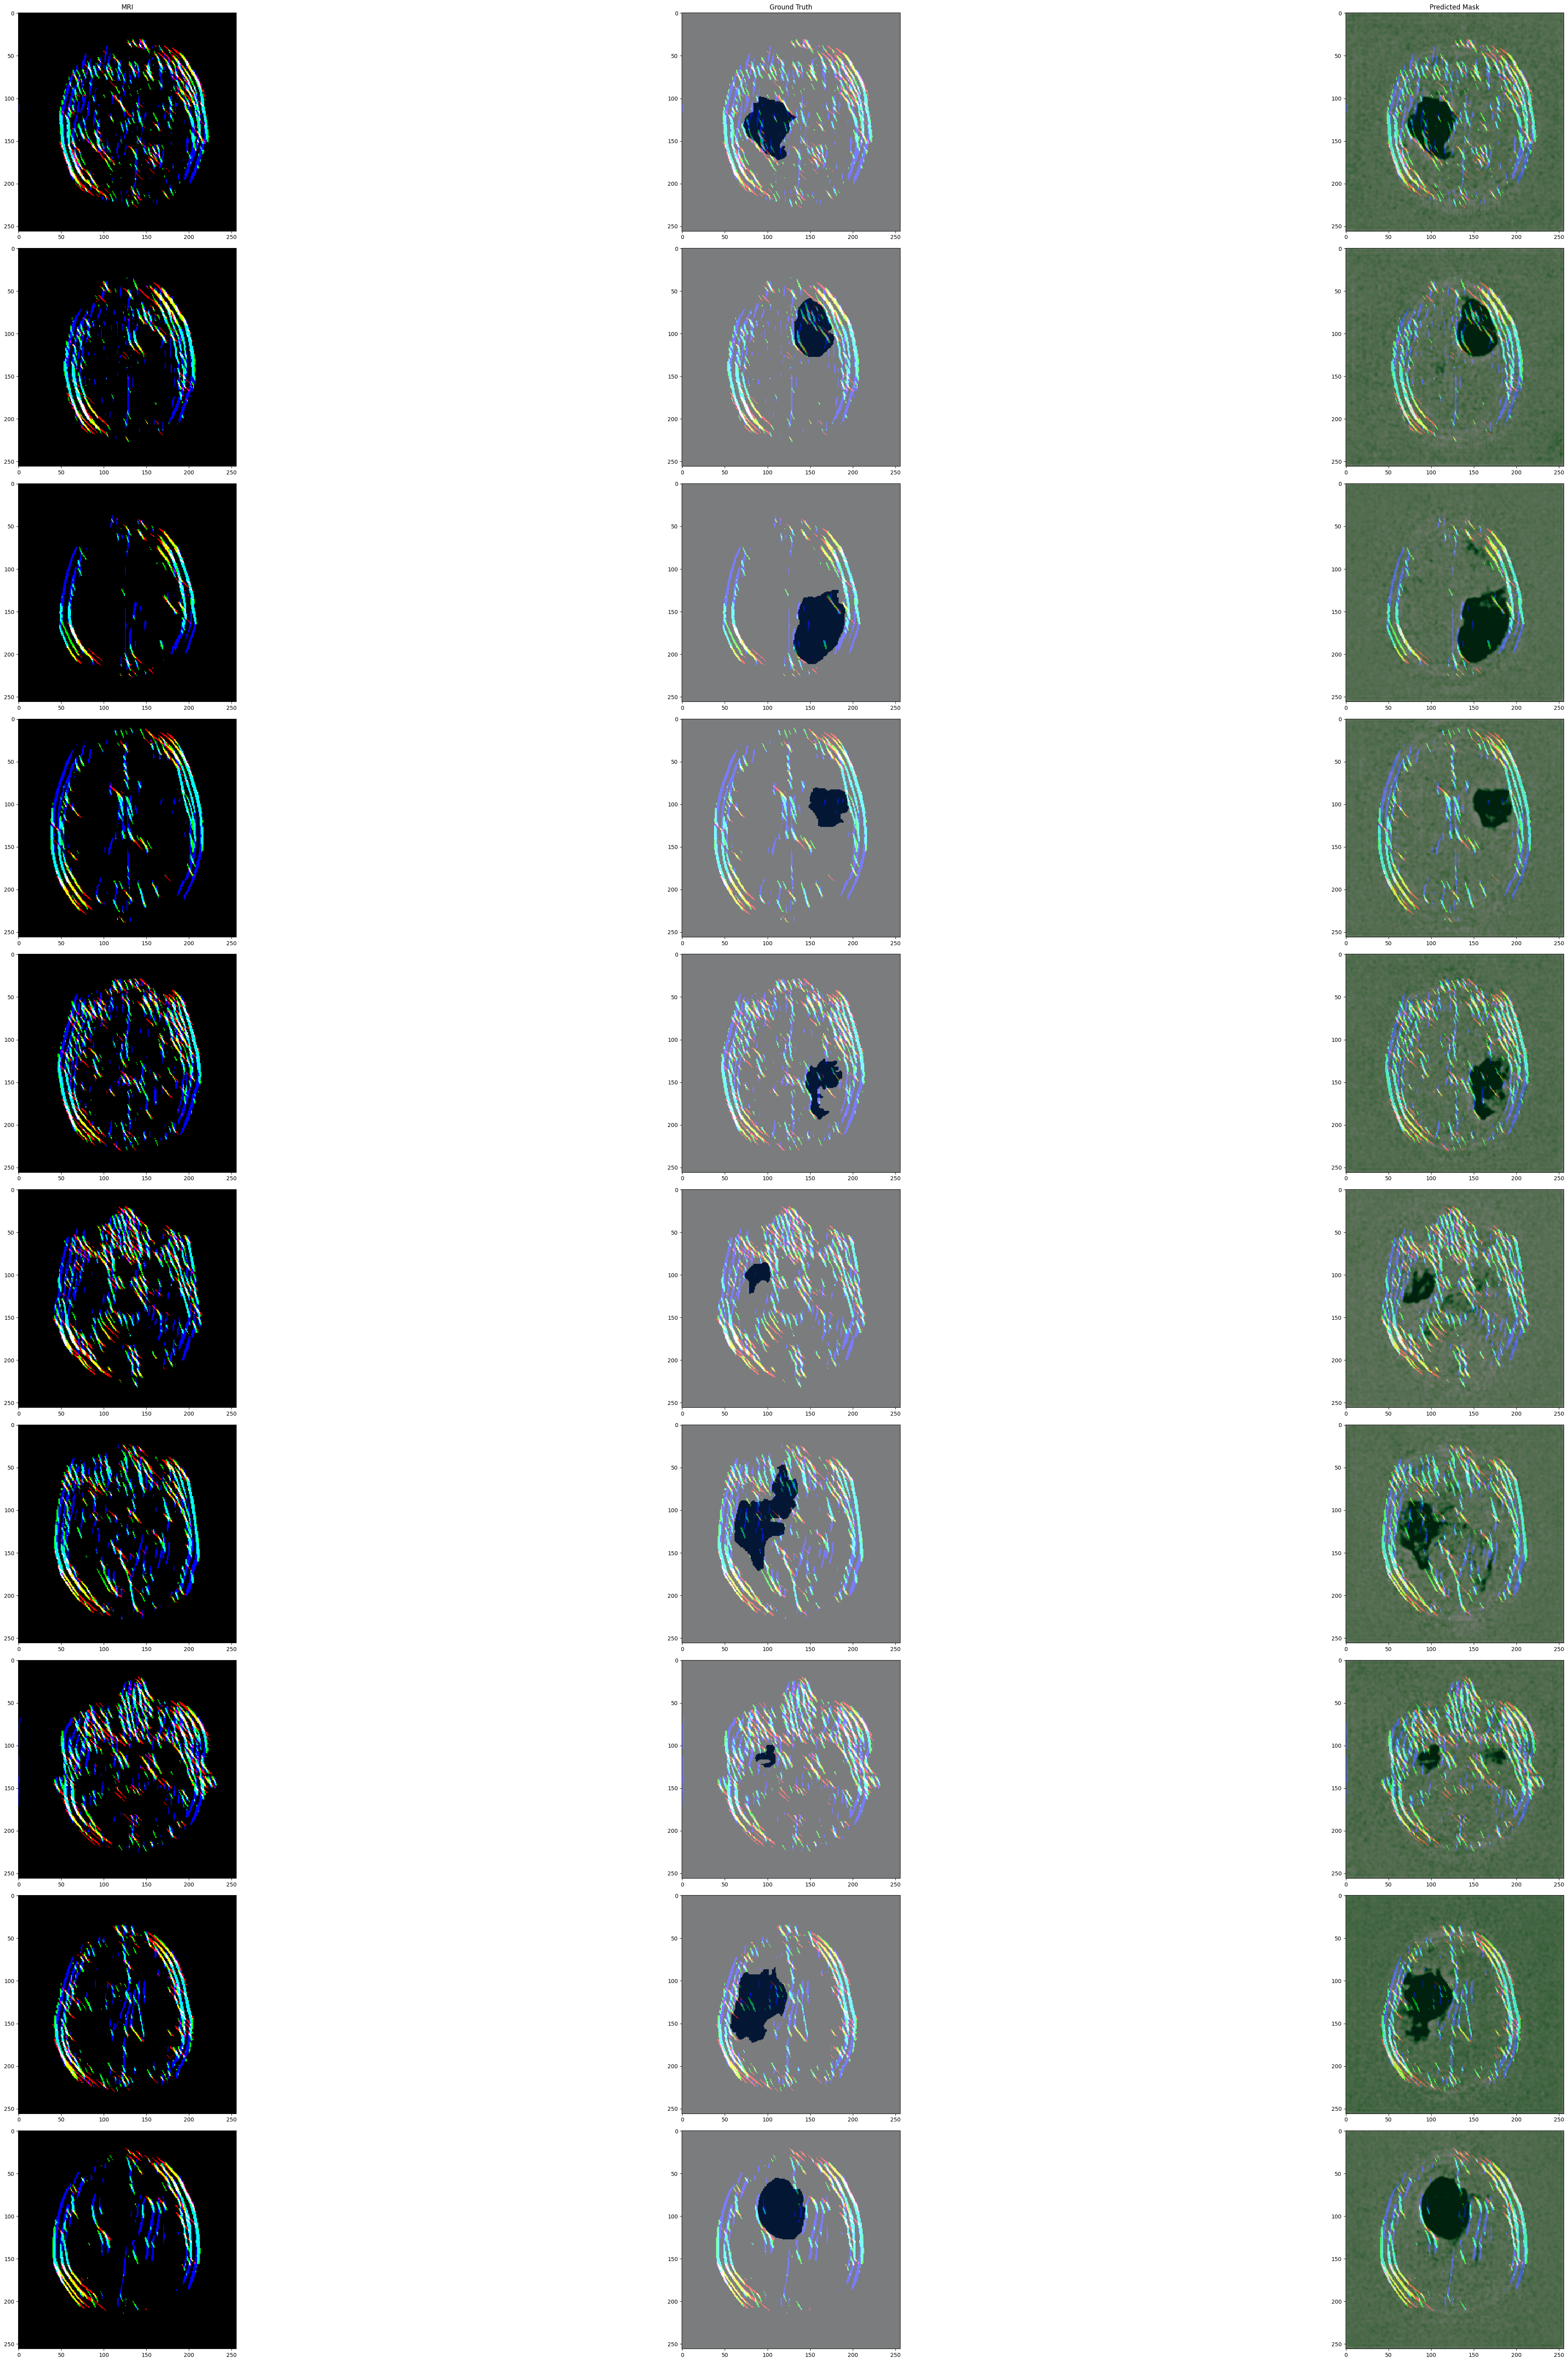

In [59]:
#visualization over unseen validation samples
visualize_segmentation(model, val_loader, num_samples=10, device='cuda:0')
del model
del optimizer
del criterion
torch.cuda.empty_cache()